In [28]:
# All required imports for API Requeest of data base
import requests
import json
from urllib3.exceptions import InsecureRequestWarning
from urllib3 import disable_warnings

# All required imports for word extraction and analysis
import pandas as pd
from pandas import json_normalize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# All required imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

## 1. Get data from MongoDB Atlas Database

In [29]:
disable_warnings(InsecureRequestWarning)

url = "https://eu-central-1.aws.data.mongodb-api.com/app/data-lkdyd/endpoint/data/v1/action/find"
payload = json.dumps({
    "collection": "wartung-log-ausfall",
    "database": "data-project",
    "dataSource": "Cluster0"
})
headers = {
  'Content-Type': 'application/json',
  'Access-Control-Request-Headers': '*',
  'api-key': 'Mlu4wzPwd6o1I1WX7XEMsopBkSZgUx6qpbewbFpwxLHnz0lkhJY5AY47NpDYzZV0',
}
response = requests.request("POST", url, headers=headers, data=payload, verify=False)
print(response.text)

{"documents":[{"_id":"65b95fd9e165317b9362ef81","MesswertID":12486,"SystemID":"A1","Datum":"01.02.2022","Zeit":"06:40","CPU":60,"RAM":60,"HD":20,"Network":30,"ServiceOK":1,"LogLevel":"Info","ServiceState":73},{"_id":"65b95fd9e165317b9362efa1","MesswertID":12518,"SystemID":"A1","Datum":"01.02.2022","Zeit":"09:20","CPU":20,"RAM":25,"HD":25,"Network":35,"ServiceOK":1,"LogLevel":"Info","ServiceState":39},{"_id":"65b95fd9e165317b9362ef8b","MesswertID":12496,"SystemID":"A1","Datum":"01.02.2022","Zeit":"07:30","CPU":20,"RAM":25,"HD":25,"Network":35,"ServiceOK":1,"LogLevel":"Info","ServiceState":58},{"_id":"65b95fd9e165317b9362efa9","MesswertID":12526,"SystemID":"A1","Datum":"01.02.2022","Zeit":"10:00","CPU":50,"RAM":50,"HD":20,"Network":30,"ServiceOK":1,"LogLevel":"Info","ServiceState":62},{"_id":"65b95fd9e165317b9362efaa","MesswertID":12527,"SystemID":"A1","Datum":"01.02.2022","Zeit":"10:05","CPU":60,"RAM":60,"HD":20,"Network":30,"ServiceOK":1,"LogLevel":"Info","ServiceState":100},{"_id":"65

In [30]:
# Convert the response to a json object
json_data = json.loads(response.text)
json_data

{'documents': [{'_id': '65b95fd9e165317b9362ef81',
   'MesswertID': 12486,
   'SystemID': 'A1',
   'Datum': '01.02.2022',
   'Zeit': '06:40',
   'CPU': 60,
   'RAM': 60,
   'HD': 20,
   'Network': 30,
   'ServiceOK': 1,
   'LogLevel': 'Info',
   'ServiceState': 73},
  {'_id': '65b95fd9e165317b9362efa1',
   'MesswertID': 12518,
   'SystemID': 'A1',
   'Datum': '01.02.2022',
   'Zeit': '09:20',
   'CPU': 20,
   'RAM': 25,
   'HD': 25,
   'Network': 35,
   'ServiceOK': 1,
   'LogLevel': 'Info',
   'ServiceState': 39},
  {'_id': '65b95fd9e165317b9362ef8b',
   'MesswertID': 12496,
   'SystemID': 'A1',
   'Datum': '01.02.2022',
   'Zeit': '07:30',
   'CPU': 20,
   'RAM': 25,
   'HD': 25,
   'Network': 35,
   'ServiceOK': 1,
   'LogLevel': 'Info',
   'ServiceState': 58},
  {'_id': '65b95fd9e165317b9362efa9',
   'MesswertID': 12526,
   'SystemID': 'A1',
   'Datum': '01.02.2022',
   'Zeit': '10:00',
   'CPU': 50,
   'RAM': 50,
   'HD': 20,
   'Network': 30,
   'ServiceOK': 1,
   'LogLevel': 'In

In [31]:
# Get response data as a dataframe
df = pd.DataFrame(json_data)
df

,documents
0,"{'_id': '65b95fd9e165317b9362ef81', 'MesswertI..."
1,"{'_id': '65b95fd9e165317b9362efa1', 'MesswertI..."
2,"{'_id': '65b95fd9e165317b9362ef8b', 'MesswertI..."
3,"{'_id': '65b95fd9e165317b9362efa9', 'MesswertI..."
4,"{'_id': '65b95fd9e165317b9362efaa', 'MesswertI..."
...,...
995,"{'_id': '65b95fd9e165317b9362f347', 'MesswertI..."
996,"{'_id': '65b95fd9e165317b9362f348', 'MesswertI..."
997,"{'_id': '65b95fd9e165317b9362f355', 'MesswertI..."
998,"{'_id': '65b95fd9e165317b9362f35c', 'MesswertI..."


In [32]:
# Use json_normalize to flatten the dictionaries into separate columns
df_normalized = json_normalize(df['documents'])

# Concatenate the normalized columns with the original DataFrame
df = pd.concat([df, df_normalized], axis=1)

# Drop the original 'documents' column if needed
df = df.drop('documents', axis=1)

# Print the resulting DataFrame
print(df)

                          _id  MesswertID SystemID       Datum   Zeit  CPU  \
0    65b95fd9e165317b9362ef81       12486       A1  01.02.2022  06:40   60   
1    65b95fd9e165317b9362efa1       12518       A1  01.02.2022  09:20   20   
2    65b95fd9e165317b9362ef8b       12496       A1  01.02.2022  07:30   20   
3    65b95fd9e165317b9362efa9       12526       A1  01.02.2022  10:00   50   
4    65b95fd9e165317b9362efaa       12527       A1  01.02.2022  10:05   60   
..                        ...         ...      ...         ...    ...  ...   
995  65b95fd9e165317b9362f347       13453       A1  07.02.2022  11:50   35   
996  65b95fd9e165317b9362f348       13454       A1  07.02.2022  11:55   20   
997  65b95fd9e165317b9362f355       13467       A1  07.02.2022  13:00   50   
998  65b95fd9e165317b9362f35c       13474       A1  07.02.2022  13:35   60   
999  65b95fd9e165317b9362f360       13478       A1  07.02.2022  13:55   20   

     RAM  HD  Network  ServiceOK LogLevel  ServiceState  \
0   

Je nach Use Case hier noch JSON bearbeiten, bevor es in das DF überführt wird

In [33]:
# Lower all the text in the dataframe

df['LowText'] = df['LogMessage'].apply(lambda x: x.lower() if isinstance(x, str) else x)


## 2. Daten für Analyse vorbereiten
Verwendete Verfahren:
- Tokenization
- Lemmatization
- Stemming

In [34]:
nltk.download('snowball_data')

[nltk_data] Downloading package snowball_data to
[nltk_data]     C:\Users\betz\AppData\Roaming\nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


True

In [35]:
#Stemming
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer("english")
print("--->Stemming:")
df['Stem'] = df['LowText'].apply(lambda x: ' '.join([snowball.stem(word) for word in str(x).split() if isinstance(x, str)]))
print(df['Stem'])

--->Stemming:
0                                  
1                                  
2                                  
3                                  
4                                  
                   ...             
995    not reachabl server endpoint
996                                
997                                
998                                
999                                
Name: Stem, Length: 1000, dtype: object


In [36]:
#download tokenzization data
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\betz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\betz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
# Tokenization
from nltk.tokenize import word_tokenize
print("--->Tokenization:")
df['Token'] = [word_tokenize(word) for word in df["Stem"]]
print(df['Token'])

--->Tokenization:
0                                     []
1                                     []
2                                     []
3                                     []
4                                     []
                     ...                
995    [not, reachabl, server, endpoint]
996                                   []
997                                   []
998                                   []
999                                   []
Name: Token, Length: 1000, dtype: object


In [38]:
# Lemmatization in english language
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
print("--->Lemmatization:")
df['Lem'] = [' '.join([lemmatizer.lemmatize(wd) for wd in word]) for word in df['Token']]
print(df['Lem'])

--->Lemmatization:
0                                  
1                                  
2                                  
3                                  
4                                  
                   ...             
995    not reachabl server endpoint
996                                
997                                
998                                
999                                
Name: Lem, Length: 1000, dtype: object


## 3. Analyse durchführen

Was müssen wir hier Analysieren? Reichen die Textdaten aus, oder müssen die Texte mit den anderen Hardware Daten verknüpft werden?

In [61]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
#Daten splitten
X_train, X_test, y_train, y_test = train_test_split(df['Stem'], df['ServiceOK'],
test_size=0.3)


In [62]:
#Vectorization of the Data
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [63]:
# Visualize the data

def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicted', fontsize=15)
    ax.set_ylabel('True', fontsize=15)
    ax.set_title(title, fontsize=15)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels, rotation=0)
    plt.show()



### 3.1 Klassifikation - K-nearest Neighbors

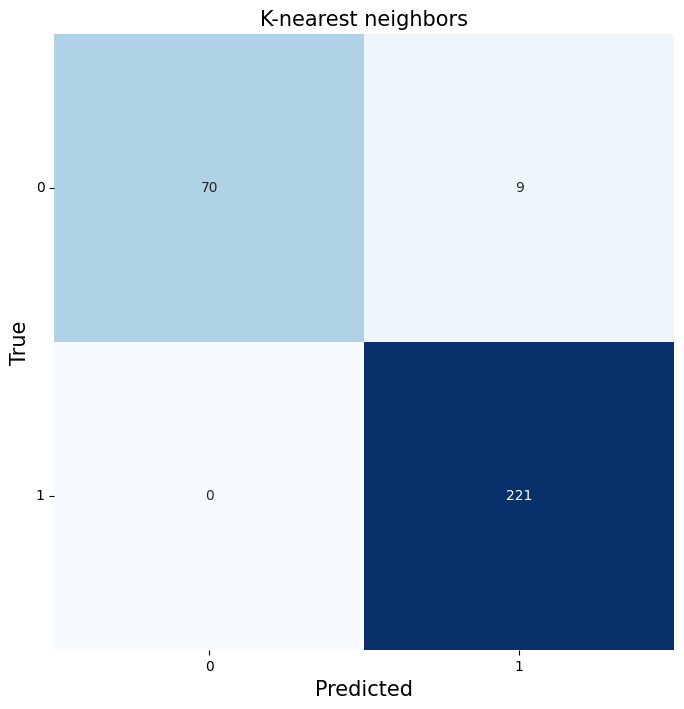

In [69]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(tfidf_train_vectors, y_train)
knn_pred = knn.predict(tfidf_test_vectors)
plot_confusion_matrix(y_test, knn_pred, "K-nearest neighbors", knn.classes_)

### 3.2 Klassifikation - Random Forest

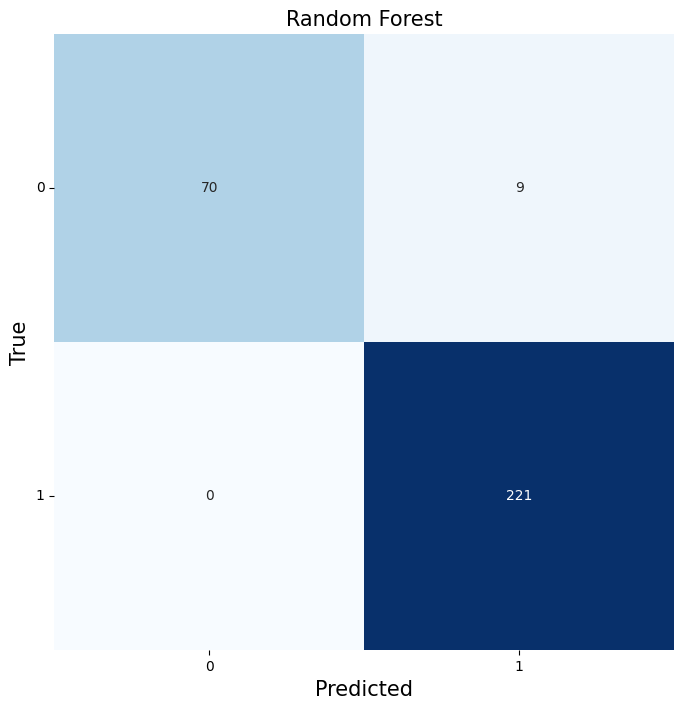

In [70]:
# Use Random Forest for classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(tfidf_train_vectors, y_train)
rf_pred = rf.predict(tfidf_test_vectors)
plot_confusion_matrix(y_test, rf_pred, "Random Forest", rf.classes_)
